# Deep Neural Network for MNIST Digit Classification

## 1. Importing Libraries and Loading Data

In [1]:

import numpy as np
import pandas as pd

# Load and preprocess datasets
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

# Normalize pixel values
X_train = train_data.iloc[:, 1:].values / 255.0
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values / 255.0
y_test = test_data.iloc[:, 0].values

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)


## 2. Deep Neural Network Implementation

This section defines the DeepNeuralNetwork class with methods for forward propagation, backward propagation, and training. It includes advanced features like Adam optimization, dropout, and learning rate scheduling.

In [2]:

class DeepNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.weights = []
        self.biases = []
        self.m_W = []
        self.m_b = []
        self.v_W = []
        self.v_b = []

        layer_input_size = input_size
        for hidden_size in hidden_sizes:
            self.weights.append(np.random.randn(layer_input_size, hidden_size) * 0.01)
            self.biases.append(np.zeros((1, hidden_size)))
            self.m_W.append(np.zeros((layer_input_size, hidden_size)))
            self.m_b.append(np.zeros((1, hidden_size)))
            self.v_W.append(np.zeros((layer_input_size, hidden_size)))
            self.v_b.append(np.zeros((1, hidden_size)))
            layer_input_size = hidden_size

        self.weights.append(np.random.randn(layer_input_size, output_size) * 0.01)
        self.biases.append(np.zeros((1, output_size)))
        self.m_W.append(np.zeros((layer_input_size, output_size)))
        self.m_b.append(np.zeros((1, output_size)))
        self.v_W.append(np.zeros((layer_input_size, output_size)))
        self.v_b.append(np.zeros((1, output_size)))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X, dropout_prob=1.0):
        self.activations = [X]
        self.pre_activations = []
        for W, b in zip(self.weights, self.biases):
            z = np.dot(self.activations[-1], W) + b
            self.pre_activations.append(z)
            activation = self.relu(z)
            self.activations.append(self.dropout(activation, dropout_prob))
        self.output = self.softmax(self.pre_activations[-1])
        return self.output

    def dropout(self, X, keep_prob):
        mask = np.random.rand(*X.shape) < keep_prob
        return X * mask / keep_prob

    def backward(self, X, y, epoch):
        m = X.shape[0]
        delta = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            if i > 0:
                dW = np.dot(self.activations[i].T, delta) / m
                db = np.sum(delta, axis=0, keepdims=True) / m

                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(self.activations[i])

                self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * dW
                self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * np.square(dW)
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * np.square(db)

                m_W_hat = self.m_W[i] / (1 - self.beta1**(epoch + 1))
                v_W_hat = self.v_W[i] / (1 - self.beta2**(epoch + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1**(epoch + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2**(epoch + 1))

                self.weights[i] -= self.learning_rate * m_W_hat / (np.sqrt(v_W_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
            else:
                dW = np.dot(X.T, delta) / m
                db = np.sum(delta, axis=0, keepdims=True) / m

                self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * dW
                self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * np.square(dW)
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * np.square(db)

                m_W_hat = self.m_W[i] / (1 - self.beta1**(epoch + 1))
                v_W_hat = self.v_W[i] / (1 - self.beta2**(epoch + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1**(epoch + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2**(epoch + 1))

                self.weights[i] -= self.learning_rate * m_W_hat / (np.sqrt(v_W_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def train(self, X, y, epochs=10, batch_size=64, validation_split=0.1):
        # Split the training data
        split_index = int(X.shape[0] * (1 - validation_split))
        X_train, X_val = X[:split_index], X[split_index:]
        y_train, y_val = y[:split_index], y[split_index:]

        # Learning rate scheduler
        def lr_schedule(epoch):
            initial_lr = self.learning_rate
            drop = 10
            decay = 0.5
            return initial_lr * (decay ** (epoch // drop))

        # Early stopping
        best_val_loss = float('inf')
        patience = 3
        patience_counter = 0

        for epoch in range(epochs):
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch, epoch)

            # Apply learning rate schedule
            self.learning_rate = lr_schedule(epoch)

            # Calculate losses
            train_loss = self.calculate_loss(X_train, y_train)
            val_loss = self.calculate_loss(X_val, y_val)
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping due to no improvement in validation loss.")
                    break

    def calculate_loss(self, X, y, lambda_=0.1):
        m = X.shape[0]
        predictions = self.forward(X)
        loss = -np.sum(y * np.log(predictions + 1e-8)) / m
        loss += (lambda_ / 2) * sum(np.sum(np.square(W)) for W in self.weights)
        return loss

    def predict(self, X):
        predictions = self.forward(X)
        return np.argmax(predictions, axis=1)


## 3. K-Fold Cross-Validation

This section implements k-fold cross-validation to evaluate the model's performance more robustly.

In [1]:

def k_fold_cross_validation(X, y, k=5, epochs=20, batch_size=64):
    fold_size = X.shape[0] // k
    accuracies = []

    for fold in range(k):
        X_val = X[fold*fold_size:(fold+1)*fold_size]
        y_val = y[fold*fold_size:(fold+1)*fold_size]
        X_train = np.concatenate([X[:fold*fold_size], X[(fold+1)*fold_size:]])
        y_train = np.concatenate([y[:fold*fold_size], y[(fold+1)*fold_size:]])

        # Initialize and train the model
        nn = DeepNeuralNetwork(input_size=X.shape[1], hidden_sizes=[512, 256, 128], output_size=10, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
        nn.train(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

        # Evaluate the model
        y_pred = nn.predict(X_val)
        accuracy = np.mean(np.argmax(y_val, axis=1) == y_pred)
        accuracies.append(accuracy)
        print(f'Fold {fold+1}/{k} - Accuracy: {accuracy * 100:.2f}%')

    print(f'Average Accuracy across {k} folds: {np.mean(accuracies) * 100:.2f}%')


## 4. Training and Evaluation

In this section, we perform k-fold cross-validation, train the final model on the full training data, and evaluate it on the test set.

In [4]:

# Perform k-fold cross-validation
k_fold_cross_validation(X_train, y_train_encoded, k=5, epochs=20, batch_size=128)

# Train the final model on the full training data
final_nn = DeepNeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[512, 256, 128], output_size=10, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
final_nn.train(X_train, y_train_encoded, epochs=20, batch_size=128, validation_split=0.1)

# Evaluate the final model on the test set
y_pred = final_nn.predict(X_test)
accuracy = np.mean(np.argmax(y_test_encoded, axis=1) == y_pred)
print(f'Final Accuracy on test set: {accuracy * 100:.2f}%')


Epoch 1/20, Train Loss: 20.33353644533642, Val Loss: 20.31683531732267
Epoch 2/20, Train Loss: 22.69925958864314, Val Loss: 22.692971385740844
Epoch 3/20, Train Loss: 24.24780699409118, Val Loss: 24.244573000903895
Epoch 4/20, Train Loss: 25.4564345219675, Val Loss: 25.455545978369976
Early stopping due to no improvement in validation loss.
Fold 1/5 - Accuracy: 97.36%
Epoch 1/20, Train Loss: 19.649506687925555, Val Loss: 19.635975576859934
Epoch 2/20, Train Loss: 22.08917303960191, Val Loss: 22.082727149311957
Epoch 3/20, Train Loss: 23.579570055679753, Val Loss: 23.577707639967024
Epoch 4/20, Train Loss: 24.73312381693002, Val Loss: 24.73397042391848
Early stopping due to no improvement in validation loss.
Fold 2/5 - Accuracy: 97.12%
Epoch 1/20, Train Loss: 18.2616389753904, Val Loss: 18.246610243289435
Epoch 2/20, Train Loss: 20.48184568055869, Val Loss: 20.472411632731543
Epoch 3/20, Train Loss: 21.872563118537176, Val Loss: 21.868866716181387
Epoch 4/20, Train Loss: 22.926958781015

Predicted Digit: 7
Confidence: 0.3085


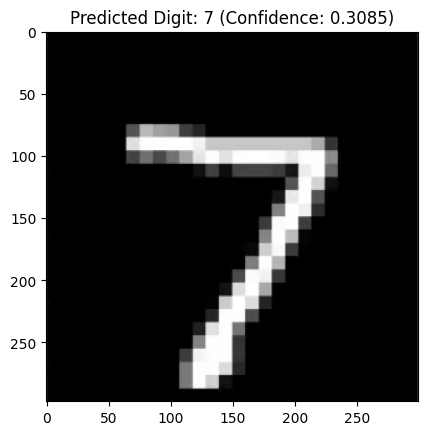

In [7]:

import numpy as np
from PIL import Image  # Ensure PIL is imported
import matplotlib.pyplot as plt
def preprocess_image(image_path, target_size=(28, 28)):
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize(target_size)  # Resize to 28x28
    img_array = np.array(img).astype(np.float32) / 255.0  # Normalize pixel values
    img_array = img_array.flatten()  # Flatten to a vector
    return img_array.reshape(1, -1)  # Reshape for the model

def predict_digit(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Get predictions from the trained model
    predictions = final_nn.predict(img_array)
    
    # Get predicted digit and confidence
    predicted_digit = predictions[0]
    confidence = np.max(final_nn.forward(img_array))  # Confidence as the max probability
    return predicted_digit, confidence

# Test with a new image
image_path = 'sample_image-300x298.webp'  # Replace with your image path
predicted_digit, confidence = predict_digit(image_path)
print(f"Predicted Digit: {predicted_digit}")
print(f"Confidence: {confidence:.4f}")

# Display the image
img = Image.open(image_path).convert('L')
plt.imshow(img, cmap='gray')
plt.title(f'Predicted Digit: {predicted_digit} (Confidence: {confidence:.4f})')
plt.show()